In [1]:
import random
import numpy as np
import pandas as pd
import time
from redis import Redis
import redisearch
from PIL import Image
from img2vec_pytorch import Img2Vec

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


# Load Amazon Product and Image metadata



In [2]:
#Load Product data and truncate long text fields
all_prods_df = pd.read_csv('data/product_image_data.csv')
all_prods_df['primary_key'] = all_prods_df['item_id'] + '-' + all_prods_df['domain_name']
all_prods_df.shape


(144217, 19)

In [3]:
all_prods_df.head(5)

,item_id,marketplace,country,main_image_id,domain_name,bullet_point,item_keywords,material,brand,color,item_name,model_name,model_number,product_type,image_id,height,width,path,primary_key
0,B07T6RZ2CM,Amazon,IN,71dZhpsferL,amazon.in,3D Printed Hard Back Case Mobile Cover for Len...,mobile cover back cover mobile case phone case...,NaN,Amazon Brand - Solimo,Others,Amazon Brand - Solimo Designer Couples Sitting...,Lenovo K4 Note,gz8115-SL40423,CELLULAR_PHONE_CASE,71dZhpsferL,2200,1879,c2/c20aa6ca.jpg,B07T6RZ2CM-amazon.in
1,B07T2JY31Y,Amazon,IN,71vX7qIEAIL,amazon.in,3D Printed Hard Back Case Mobile Cover for Son...,mobile cover back cover mobile case phone case...,Wood,Amazon Brand - Solimo,others,Amazon Brand - Solimo Designer Leaf on Wood 3D...,Sony Xperia Z1 L39H,gz8056-SL40528,CELLULAR_PHONE_CASE,71vX7qIEAIL,2200,1879,30/3079540e.jpg,B07T2JY31Y-amazon.in
2,B0849YGSCZ,Amazon,AE,A1EZF-2mB5L,amazon.ae,NaN,small de fur rooms navidad woven girls shag pa...,NaN,Stone & Beam,NaN,Stone & Beam Contemporary Doily Wool Farmhouse...,NaN,I59I8044IVYGRYC00-Parent,HOME_FURNITURE_AND_DECOR,A1EZF-2mB5L,2560,2074,f9/f9a7cb71.jpg,B0849YGSCZ-amazon.ae
3,B081K6TCML,Amazon,IN,81o9EyZ-fAL,amazon.in,Solimo Plastic Multipurpose Modular Drawer; sm...,drawer modular drawer 3 rack modular drawer ki...,Plastic,Amazon Brand - Solimo,Multicolor,Amazon Brand - Solimo Plastic Multipurpose Mod...,NaN,sol_cujo_13,HOME,81o9EyZ-fAL,2560,2077,26/26ae5dfc.jpg,B081K6TCML-amazon.in
4,B0854774X5,Amazon,IN,81xaJCVnl3L,amazon.in,"Snug fit for Nokia 8.1, with perfect cut-outs ...",Back Cover Designer Case Designer Take It Easy...,Silicon,Amazon Brand - Solimo,Multicolor,Amazon Brand - Solimo Designer Take It Easy UV...,Nokia 8.1,UV10714-SL40617,CELLULAR_PHONE_CASE,81xaJCVnl3L,2200,1879,5d/5d8f395f.jpg,B0854774X5-amazon.in


# Connect to Redis

In [4]:
host = 'localhost'
port = 6379
redis_conn = Redis(host = host, port = port)
print ('Connected to redis')

Connected to redis


# Generate Embeddings

We will use 'Img2Vec' to generate embeddings (vectors) for 1K product images

https://github.com/christiansafka/img2vec

In [5]:
img2vec = Img2Vec(cuda=False)

/Users/edsandoval/opt/anaconda3/envs/vsim/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +



By Default, Img2Vect uses **'resnet-18'** as the neural network architecture to generate embeddings. In particular, each image is run through this network and the output at the  'avgpool' layer will be returned 

The output of the 'avgpool' layer in **'resnet-18' has 512 dimensions** so a single 512-float vector will be generated for every image converted

In [6]:
NUMBER_PRODUCTS=5
IMAGE_PATH = './data/images/small/'
PRODUCT_IMAGE_VECTOR_FIELD='product_image_vector'
IMAGE_VECTOR_DIMENSION=512

#subset_df = all_prods_df.head(NUMBER_PRODUCTS)
subset_df=all_prods_df.iloc[[0, 1, 47,596,859]]
subset_df.reset_index(drop=True, inplace=True)
subset_df.shape

(5, 19)

In [7]:
subset_df.head()

,item_id,marketplace,country,main_image_id,domain_name,bullet_point,item_keywords,material,brand,color,item_name,model_name,model_number,product_type,image_id,height,width,path,primary_key
0,B07T6RZ2CM,Amazon,IN,71dZhpsferL,amazon.in,3D Printed Hard Back Case Mobile Cover for Len...,mobile cover back cover mobile case phone case...,NaN,Amazon Brand - Solimo,Others,Amazon Brand - Solimo Designer Couples Sitting...,Lenovo K4 Note,gz8115-SL40423,CELLULAR_PHONE_CASE,71dZhpsferL,2200,1879,c2/c20aa6ca.jpg,B07T6RZ2CM-amazon.in
1,B07T2JY31Y,Amazon,IN,71vX7qIEAIL,amazon.in,3D Printed Hard Back Case Mobile Cover for Son...,mobile cover back cover mobile case phone case...,Wood,Amazon Brand - Solimo,others,Amazon Brand - Solimo Designer Leaf on Wood 3D...,Sony Xperia Z1 L39H,gz8056-SL40528,CELLULAR_PHONE_CASE,71vX7qIEAIL,2200,1879,30/3079540e.jpg,B07T2JY31Y-amazon.in
2,B08F4DQFP2,Amazon,FR,71qXvJLzyTL,amazon.fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4DQFP2-amazon.fr
3,B08F4KRF5P,Amazon,IT,71qXvJLzyTL,amazon.it,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4KRF5P-amazon.it
4,B08F4L58XP,Amazon,ES,71qXvJLzyTL,amazon.es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4L58XP-amazon.es


# Some Utility Functions to Generate Vectors from Images

Product images are stored under the 'data/small' folder

Every product has metadata indicating the full path to the main product image


The 'generate_img2vec_dict' function below simply takes:
* A dataframe with product metadata
* The folder where images are stored
* A batch size to generate image vectors for a batch of products in one call

The output will be a dictionary mapping 'full image path' to its corresponding vector generated

In [8]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def generate_img2vec_dict(df,image_path, batch_size=500):
    output_dict={}

    for batch in chunker(df, batch_size):
        image_filenames=batch['path'].values.tolist()
        images=[]
        unable_to_convert=[]
        for img_fn in image_filenames:
            try:
                img = Image.open(image_path + img_fn)
                images.append(img)
            except:
                unable_to_convert.append(img_fn)
                continue
        
        #Generate vectors for all images in this batch
        vec_list = img2vec.get_vec(images)
        
        #update the dictionary to be returned
        image_vectors_generated = set(image_filenames)-set(unable_to_convert)
        batch_dict= dict(zip(image_vectors_generated, vec_list))
        output_dict.update(batch_dict)
        
    return output_dict


### Time to generate the vectors!

This may take 30-60 seconds depending on your set up

In [9]:
%%time
img2vec_dict = generate_img2vec_dict(subset_df,IMAGE_PATH,batch_size=500)


(5, 512)
CPU times: user 299 ms, sys: 50.5 ms, total: 349 ms
Wall time: 302 ms


In [10]:
print (str(len(img2vec_dict.keys())) + ' keys')
#print (img2vec_dict.keys())

3 keys


### Check the Dimensions of one of the vectors generated

In [11]:
first_key = next(iter(img2vec_dict))
first_vector = img2vec_dict[first_key]
first_vector.shape[0]

512

In [12]:
#image_vectors = [img2vec_dict[image_path] for image_path in subset_df['path'].sort_index(ascending=True)]

#image_vectors=[]
#for index, row in subset_df.sort_index().iterrows():
#    print('index = ' + str(index))
#    #print (row['path'] + ' **** ' + row['item_name'])
#    img_path = row['path']    
#    vec = img2vec_dict[img_path]
#    image_vectors.append(vec)

#print (str(len(image_vectors)) + ' vectors')




In [13]:


#image_vectors=list(img2vec_dict.values())
#print((image_vectors[1]==image_vectors[1]).all())
#type(image_vectors[0].astype(np.float32))


# Utility Functions to Load Product metadata and image data
Each product will be stored in a redis hash
* **Hash Key** = **product:primary_key**
* **Hash Fields:** 
    * Item Id
    * Item Name
    * Product Image vector = 512-float vector
 

In [14]:
def load_vectors(client:Redis, product_df, vector_dict,vector_field_name):
    p = client.pipeline(transaction=False)
    for index, row in product_df.sort_index().iterrows():    
        #hash key
        key='product:'+ product_df.iloc[index]['primary_key']
        #hash fields
        item_id=product_df.iloc[index]['item_id']
        item_path=product_df.iloc[index]['path']
        item_name=product_df.iloc[index]['item_name']
        
        #retrieve vector for product image 
        product_image_vector = vector_dict[item_path].astype(np.float32).tobytes()
        
        product_data_values ={'item_id':item_id,
                 'item_name':item_name,
                 'item_path':item_path,
                 vector_field_name:product_image_vector}
        
        p.hset(key,mapping=product_data_values)
    p.execute()

# Utility Functions to Create Indexes on Vector field

In [15]:
def create_bf_index (redis_conn,index_name,vector_field_name,number_of_vectors, vector_dimensions=IMAGE_VECTOR_DIMENSION, distance_metric='L2'):
    bf_index = redisearch.Client(index_name, conn=redis_conn)
    bf_index.redis.execute_command("FT.CREATE", index_name, "SCHEMA",vector_field_name, "VECTOR", "FLOAT32", vector_dimensions, distance_metric, "BF", "INITIAL_CAP", number_of_vectors)
    return bf_index

def create_hnsw_index (redis_conn,index_name,vector_field_name,number_of_vectors, vector_dimensions=IMAGE_VECTOR_DIMENSION, distance_metric='L2',M=40,EF=200):
    hnsw_index = redisearch.Client(index_name, conn=redis_conn)
    hnsw_index.redis.execute_command("FT.CREATE", index_name, "SCHEMA", vector_field_name, "VECTOR", "FLOAT32", vector_dimensions, distance_metric, "HNSW", "INITIAL_CAP", number_of_vectors, "M", M, "EF", EF)
    return hnsw_index

def delete_data(client: Redis):
    client.flushall()

def delete_index(vector_index):
    delete_data(vector_index.redis)
    

# Utility Functions to Perform Similarity Search 
Using different indexing methods

In [16]:
def find_similar_products_bf(product_image, image_encoder, vector_index,vector_field_name, topK=5):
    #vectorize the image
    query_vector = image_encoder.get_vec(product_image).astype(np.float32).tobytes()
    #prepare the query
    q = redisearch.Query(f'@{vector_field_name}:[$vec_param TOPK {topK}]').sort_by(f'{vector_field_name}_score').paging(0,topK).return_fields(f'{vector_field_name}_score','item_name','item_id','item_path')
    #Execute the query
    results = vector_index.search(q, query_params = {'vec_param': query_vector})
    return results 

def find_similar_products_hnsw(product_image, image_encoder, vector_index,vector_field_name, topK=5,EF=5):
    #vectorize the image
    query_vector = image_encoder.get_vec(product_image).astype(np.float32).tobytes()
    #prepare the query
    q = redisearch.Query(f'@{vector_field_name}:[$vec_param TOPK {topK}]  => {{$EFRUNTIME : {EF}}}').sort_by(f'{vector_field_name}_score').paging(0,topK).return_fields(f'{vector_field_name}_score','item_name','item_id','item_path')
    #Execute the query
    results = vector_index.search(q, query_params = {'vec_param': query_vector})
    return results 



# Brute-Force - Load and Index Product Data
Load and index product data using a brute-force Index on the 'item_keywords_vector' field.
This index is used to calculate Top K Exact Nearest Neighbors of a given vector

In [17]:
%%time

print ('Loading and Indexing + ' +  str(NUMBER_PRODUCTS) + ' products')

my_bf_index = create_bf_index(redis_conn,'my_bf_index',
                              PRODUCT_IMAGE_VECTOR_FIELD,
                              NUMBER_PRODUCTS,
                              IMAGE_VECTOR_DIMENSION,
                              'L2')


load_vectors(my_bf_index.redis,subset_df,img2vec_dict,PRODUCT_IMAGE_VECTOR_FIELD)

Loading and Indexing + 5 products
CPU times: user 5.59 ms, sys: 2.2 ms, total: 7.79 ms
Wall time: 10.5 ms


# Brute-Force - FIND The Top 5 MOST VISUALLY Similar Products
Let's use the brute-force index to find the exact top 5 nearest neighbors of a given image



nan
87/87c11ce5.jpg


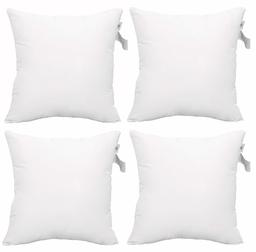

In [18]:
pos=2
print (subset_df.iloc[pos]['item_name'])
print (subset_df.iloc[pos]['path'])
queryImage = Image.open(IMAGE_PATH + subset_df.iloc[pos]['path'])
queryImage


***************Product  found ************
hash key = product:B07T2JY31Y-amazon.in
Item Name = Amazon Brand - Solimo Designer Leaf on Wood 3D Printed Hard Back Case Mobile Cover for Sony Xperia Z1 L39H
Item Id = B07T2JY31Y


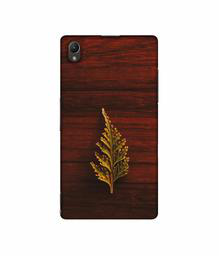

***************Product  found ************
hash key = product:B07T6RZ2CM-amazon.in
Item Name = Amazon Brand - Solimo Designer Couples Sitting at Dark 3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note
Item Id = B07T6RZ2CM


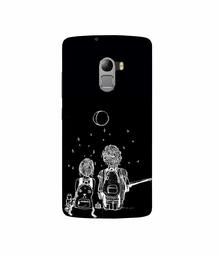

***************Product  found ************
hash key = product:B08F4L58XP-amazon.es
Item Name = nan
Item Id = B08F4L58XP


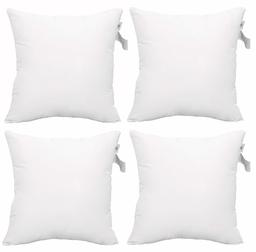

***************Product  found ************
hash key = product:B08F4KRF5P-amazon.it
Item Name = nan
Item Id = B08F4KRF5P


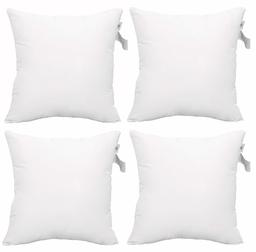

***************Product  found ************
hash key = product:B08F4DQFP2-amazon.fr
Item Name = nan
Item Id = B08F4DQFP2


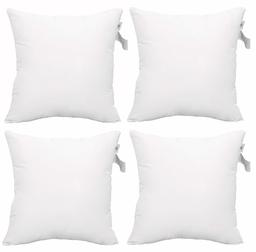

CPU times: user 121 ms, sys: 23.2 ms, total: 145 ms
Wall time: 142 ms


In [19]:
%%time

results = find_similar_products_bf (queryImage,img2vec,my_bf_index,
                                    PRODUCT_IMAGE_VECTOR_FIELD,5)

for product in results.docs:
    print ('***************Product  found ************')
    print (color.BOLD + 'hash key = ' +  color.END + product.id)
    print (color.YELLOW + 'Item Name = ' +  color.END  + product.item_name)
    print (color.YELLOW + 'Item Id = ' +  color.END  + product.item_id)
    result_img= Image.open(IMAGE_PATH + product.item_path)
    display(result_img)

## Examine Search Results

You can see the redis hash fields projected in the query (e.g item_name, item_path,item_id). 

The score field returs the distance between the query vector to each of the vectors in the result

In [20]:
results.docs

[Document {'id': 'product:B07T2JY31Y-amazon.in', 'payload': None, 'product_image_vector_score': '0', 'item_name': 'Amazon Brand - Solimo Designer Leaf on Wood 3D Printed Hard Back Case Mobile Cover for Sony Xperia Z1 L39H', 'item_id': 'B07T2JY31Y', 'item_path': '30/3079540e.jpg'},
 Document {'id': 'product:B07T6RZ2CM-amazon.in', 'payload': None, 'product_image_vector_score': '670.826477051', 'item_name': 'Amazon Brand - Solimo Designer Couples Sitting at Dark 3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note', 'item_id': 'B07T6RZ2CM', 'item_path': 'c2/c20aa6ca.jpg'},
 Document {'id': 'product:B08F4L58XP-amazon.es', 'payload': None, 'product_image_vector_score': '758.096557617', 'item_name': 'nan', 'item_id': 'B08F4L58XP', 'item_path': '87/87c11ce5.jpg'},
 Document {'id': 'product:B08F4KRF5P-amazon.it', 'payload': None, 'product_image_vector_score': '758.096557617', 'item_name': 'nan', 'item_id': 'B08F4KRF5P', 'item_path': '87/87c11ce5.jpg'},
 Document {'id': 'product:B08F4DQFP2

In [21]:
#Delete index and underlying data
delete_index(my_bf_index)


# HNSW - Load and Index Product Data
Load and index product data using an HNSW Index on the 'item_keywords_vector' field.
This index is used to calculate Top K Approximate Nearest Neighbors of a given vector

In [22]:
%%time
print ('Loading and Indexing + ' +  str(NUMBER_PRODUCTS) + ' products')
my_hnsw_index = create_hnsw_index(redis_conn,'my_hnsw_index',PRODUCT_IMAGE_VECTOR_FIELD,NUMBER_PRODUCTS,IMAGE_VECTOR_DIMENSION,'L2',M=40,EF=200)
load_vectors(my_hnsw_index.redis,subset_df,img2vec_dict,PRODUCT_IMAGE_VECTOR_FIELD)

Loading and Indexing + 5 products
CPU times: user 6.75 ms, sys: 1.96 ms, total: 8.71 ms
Wall time: 10.4 ms


# HNSW - Query The Top 5 Similar Products
Let's repeat the similarity search but this time using the HNSW index




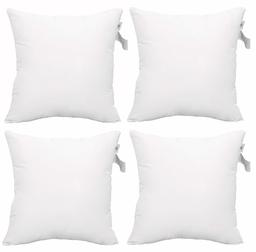

In [23]:
queryImage

***************Product  found ************
hash key = product:B07T2JY31Y-amazon.in
Item Name = Amazon Brand - Solimo Designer Leaf on Wood 3D Printed Hard Back Case Mobile Cover for Sony Xperia Z1 L39H
Item Id = B07T2JY31Y


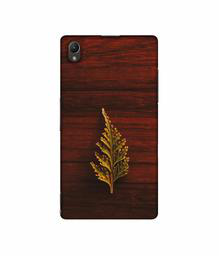

***************Product  found ************
hash key = product:B07T6RZ2CM-amazon.in
Item Name = Amazon Brand - Solimo Designer Couples Sitting at Dark 3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note
Item Id = B07T6RZ2CM


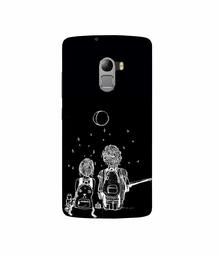

***************Product  found ************
hash key = product:B08F4L58XP-amazon.es
Item Name = nan
Item Id = B08F4L58XP


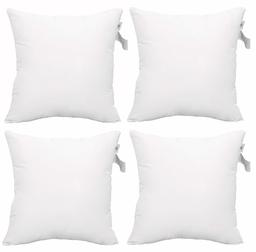

***************Product  found ************
hash key = product:B08F4KRF5P-amazon.it
Item Name = nan
Item Id = B08F4KRF5P


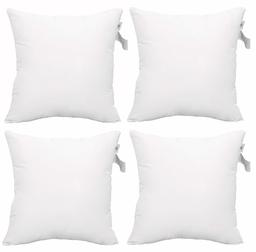

***************Product  found ************
hash key = product:B08F4DQFP2-amazon.fr
Item Name = nan
Item Id = B08F4DQFP2


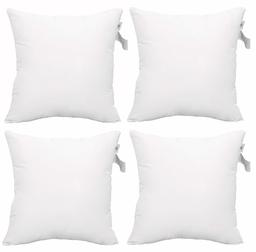

CPU times: user 126 ms, sys: 18.4 ms, total: 144 ms
Wall time: 131 ms


In [24]:
%%time

results = find_similar_products_hnsw (queryImage,img2vec,my_hnsw_index,PRODUCT_IMAGE_VECTOR_FIELD,5,EF=5)
for product in results.docs:
    print ('***************Product  found ************')
    print (color.BOLD + 'hash key = ' +  color.END + product.id)
    print (color.YELLOW + 'Item Name = ' +  color.END  + product.item_name)
    print (color.YELLOW + 'Item Id = ' +  color.END  + product.item_id)
    result_img= Image.open(IMAGE_PATH + product.item_path)
    display(result_img)

In [25]:
results.docs

[Document {'id': 'product:B07T2JY31Y-amazon.in', 'payload': None, 'product_image_vector_score': '0', 'item_name': 'Amazon Brand - Solimo Designer Leaf on Wood 3D Printed Hard Back Case Mobile Cover for Sony Xperia Z1 L39H', 'item_id': 'B07T2JY31Y', 'item_path': '30/3079540e.jpg'},
 Document {'id': 'product:B07T6RZ2CM-amazon.in', 'payload': None, 'product_image_vector_score': '670.826477051', 'item_name': 'Amazon Brand - Solimo Designer Couples Sitting at Dark 3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note', 'item_id': 'B07T6RZ2CM', 'item_path': 'c2/c20aa6ca.jpg'},
 Document {'id': 'product:B08F4L58XP-amazon.es', 'payload': None, 'product_image_vector_score': '758.096557617', 'item_name': 'nan', 'item_id': 'B08F4L58XP', 'item_path': '87/87c11ce5.jpg'},
 Document {'id': 'product:B08F4KRF5P-amazon.it', 'payload': None, 'product_image_vector_score': '758.096557617', 'item_name': 'nan', 'item_id': 'B08F4KRF5P', 'item_path': '87/87c11ce5.jpg'},
 Document {'id': 'product:B08F4DQFP2

In [26]:
#cleanup
delete_index(my_hnsw_index)

In [27]:
col=subset_df[subset_df['path']=='87/87c11ce5.jpg']

In [28]:
col.head()

,item_id,marketplace,country,main_image_id,domain_name,bullet_point,item_keywords,material,brand,color,item_name,model_name,model_number,product_type,image_id,height,width,path,primary_key
2,B08F4DQFP2,Amazon,FR,71qXvJLzyTL,amazon.fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4DQFP2-amazon.fr
3,B08F4KRF5P,Amazon,IT,71qXvJLzyTL,amazon.it,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4KRF5P-amazon.it
4,B08F4L58XP,Amazon,ES,71qXvJLzyTL,amazon.es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOME,71qXvJLzyTL,2523,2560,87/87c11ce5.jpg,B08F4L58XP-amazon.es
